In [1]:
from operator import mod
from tomo2mesh.misc.voxel_processing import TimerGPU, edge_map, modified_autocontrast, get_values_cyl_mask, cylindrical_mask
from tomo2mesh.projects.eaton.recon import recon_binned, recon_all
from tomo2mesh.projects.eaton.params import pixel_size_1X as pixel_size
from tomo2mesh.projects.eaton.rw_utils import read_raw_data_1X, save_path
from tomo2mesh.unet3d.surface_segmenter import SurfaceSegmenter
from tomo2mesh.structures.grid import Grid

import cupy as cp
import numpy as np
from tomo2mesh.structures.voids import Voids
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from cupyx.scipy import ndimage
from scipy import ndimage as ndimage_cpu
import matplotlib.pyplot as plt



In [2]:
b = 1
projs, theta, center, dark, flat = read_raw_data_1X("89", "7")
t_gpu = TimerGPU("secs")
memory_pool = cp.cuda.MemoryPool()
cp.cuda.set_allocator(memory_pool.malloc)

ntheta, nz, n = projs.shape
projs = np.mean(projs.reshape(ntheta,nz//b,b,n//b,b), axis = (2,4))
projs = np.array(projs, dtype = np.float32)
dark = np.mean(dark.reshape(nz//b, b, n//b, b), axis = (1,3))
flat = np.mean(flat.reshape(nz//b, b, n//b, b), axis = (1,3))
dark = np.array(dark.astype(np.float32), dtype = np.float32)
flat = np.array(flat.astype(np.float32), dtype = np.float32)
theta = np.array(theta, dtype = np.float32)
center = np.float32(center/float(b))

# fbp
t_gpu.tic()
V_ubin = recon_all(projs, theta, center, 32, dark, flat, pixel_size)
Vrec_ubin = V_ubin[0:128,:(n//128)*128,:(n//128)*128] #32

# binarize 
model_tag = "M_b02" #7
model_names = {"segmenter" : "segmenter_Unet_%s"%model_tag}
model_path = '/data01/Eaton_Polymer_AM/models'
segmenter = SurfaceSegmenter(model_initialization = 'load-model', \
                        model_names = model_names, \
                        model_path = model_path)    


patches = Grid(Vrec_ubin.shape, width = 128) #32
x_rec = patches.extract(Vrec_ubin)
min_max = modified_autocontrast(Vrec_ubin[::2,::2,::2].reshape(-1), s = 0.01)
#min_max = (Vrec_ubin[::2,::2,::2].min(), Vrec_ubin[::2,::2,::2].max())
y_pred = segmenter.predict_patches("segmenter", x_rec[...,np.newaxis], 4, None, min_max = min_max) #128
Vseg_ubin = np.empty(Vrec_ubin.shape)
patches.fill_patches_in_volume(y_pred[...,0], Vseg_ubin)

# voxel_values = get_values_cyl_mask(Vrec_ubin, 1.0)
# thresh = np.float32(threshold_otsu(voxel_values))    
# Vseg_ubin = (Vrec_ubin<thresh).astype(np.uint8)
# cylindrical_mask(Vseg_ubin, 1, mask_val = 1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [01:33<00:00,  2.59s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [01:01<00:00,  1.48it/s]


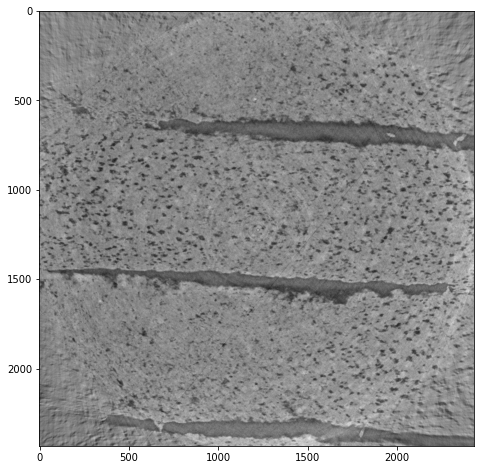

In [3]:
#Plot reconstructed slice
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.imshow(Vrec_ubin[100], cmap = 'gray')
plt.show()


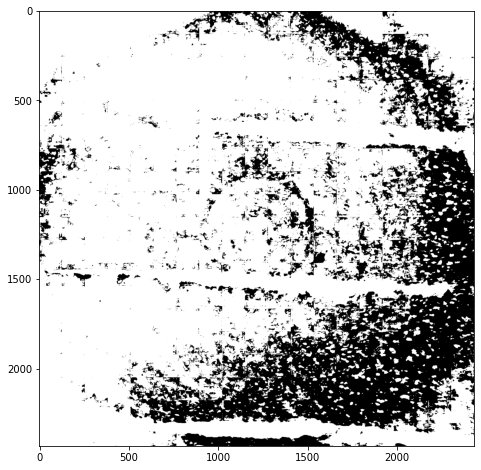

In [4]:
#Plot segmented slice
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.imshow(Vseg_ubin[100], cmap = 'gray')
plt.show()


<AxesSubplot:>

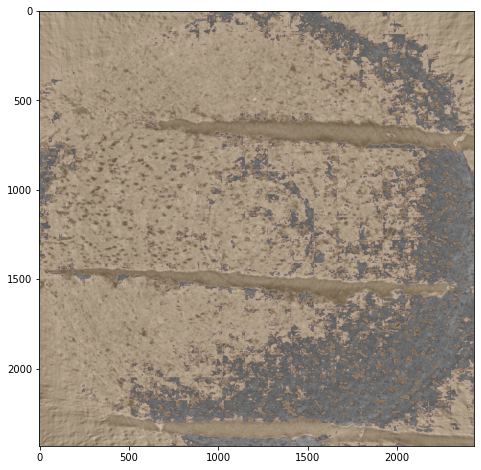

In [5]:
#Overlay plot
from tomo2mesh.misc import viewer
fig, ax = plt.subplots(1,1, figsize = (8,8))
viewer.seg_plot(Vrec_ubin[100],Vseg_ubin[100], ax)
